In [1]:
import pandas as pd

# Try reading as a normal CSV file
file_path = "AAVEUSDT.csv.gzip"  # Update the path if needed
df = pd.read_csv(file_path)  # Removed compression="gzip"

# Display first few rows to verify
print(df.head())


   Unnamed: 0            timestamp    open    high     low   close  volume  \
0           0  2021-01-01 00:00:00  88.581  88.734  88.475  88.600   183.5   
1           1  2021-01-01 00:01:00  88.686  88.708  88.559  88.647    81.8   
2           2  2021-01-01 00:02:00  88.568  88.660  88.421  88.421   148.5   
3           3  2021-01-01 00:03:00  88.513  88.513  88.256  88.335   166.0   
4           4  2021-01-01 00:04:00  88.367  88.498  88.299  88.470   259.0   

      close_time    quote_av  trades  tb_base_av  tb_quote_av  ignore  
0  1609459259999  16268.2382      62       142.9   12672.0879       0  
1  1609459319999   7252.6521      39        43.3    3840.4015       0  
2  1609459379999  13150.7434      41        32.3    2862.9951       0  
3  1609459439999  14665.5388      49        20.7    1828.1408       0  
4  1609459499999  22888.3414      38       230.1   20335.7561       0  


In [2]:
import pandas as pd

# ======= Step 1: Load the Dataset =======
file_path = "AAVEUSDT.csv.gzip"  # Update if needed
df = pd.read_csv(file_path)

# ======= Step 2: Remove Unnecessary Columns =======
df = df.drop(columns=["Unnamed: 0", "close_time", "ignore"], errors="ignore")

# ======= Step 3: Convert Timestamp to Datetime Format =======
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ======= Step 4: Resample Data to Hourly Intervals =======
df_resampled = df.resample('1H', on='timestamp').mean().dropna()

# ======= Step 5: Save Processed Dataset =======
df_resampled.to_csv("processed_AAVEUSDT_hourly.csv", index=False)
print("Processed dataset saved as 'processed_AAVEUSDT_hourly.csv'.")

# ======= Step 6: Display First Few Rows =======
print(df_resampled.head())


C:\Users\shiva\AppData\Local\Temp\ipykernel_14152\1866501261.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('1H', on='timestamp').mean().dropna()


Processed dataset saved as 'processed_AAVEUSDT_hourly.csv'.
                          open       high        low      close      volume  \
timestamp                                                                     
2021-01-01 00:00:00  87.078183  87.193517  86.973133  87.065483  482.811667   
2021-01-01 01:00:00  87.821200  87.932133  87.710800  87.803767  391.631667   
2021-01-01 02:00:00  87.154383  87.249100  87.069367  87.157650  227.720000   
2021-01-01 03:00:00  88.421717  88.526850  88.346933  88.426200  229.650000   
2021-01-01 04:00:00  88.172167  88.270083  88.071517  88.162767  270.246667   

                         quote_av     trades  tb_base_av   tb_quote_av  
timestamp                                                               
2021-01-01 00:00:00  42044.680132  98.200000  228.996667  19958.955470  
2021-01-01 01:00:00  34421.372993  85.316667  170.961667  15040.955652  
2021-01-01 02:00:00  19844.127042  62.583333  105.726667   9219.294343  
2021-01-01 03:00:00  

In [3]:
import pandas as pd

# Load the processed dataset
file_path = "processed_AAVEUSDT_hourly.csv"
df = pd.read_csv(file_path)

# Reset index to bring back the "timestamp" column
df.reset_index(inplace=True)

# Convert timestamp back to datetime format
df["timestamp"] = pd.to_datetime(df["index"])
df.drop(columns=["index"], inplace=True)  # Drop the temporary index column

# Save the updated dataset
updated_file_path = "fixed_AAVEUSDT_hourly.csv"
df.to_csv(updated_file_path, index=False)  # Save without index

# Confirm saved file
print(f"Updated dataset saved as '{updated_file_path}'")

# Check the first few rows
print(df.head())


Updated dataset saved as 'fixed_AAVEUSDT_hourly.csv'
        open       high        low      close      volume      quote_av  \
0  87.078183  87.193517  86.973133  87.065483  482.811667  42044.680132   
1  87.821200  87.932133  87.710800  87.803767  391.631667  34421.372993   
2  87.154383  87.249100  87.069367  87.157650  227.720000  19844.127042   
3  88.421717  88.526850  88.346933  88.426200  229.650000  20324.513678   
4  88.172167  88.270083  88.071517  88.162767  270.246667  23880.126850   

      trades  tb_base_av   tb_quote_av                     timestamp  
0  98.200000  228.996667  19958.955470 1970-01-01 00:00:00.000000000  
1  85.316667  170.961667  15040.955652 1970-01-01 00:00:00.000000001  
2  62.583333  105.726667   9219.294343 1970-01-01 00:00:00.000000002  
3  64.050000  101.183333   8954.714327 1970-01-01 00:00:00.000000003  
4  69.233333  103.030000   9117.159793 1970-01-01 00:00:00.000000004  


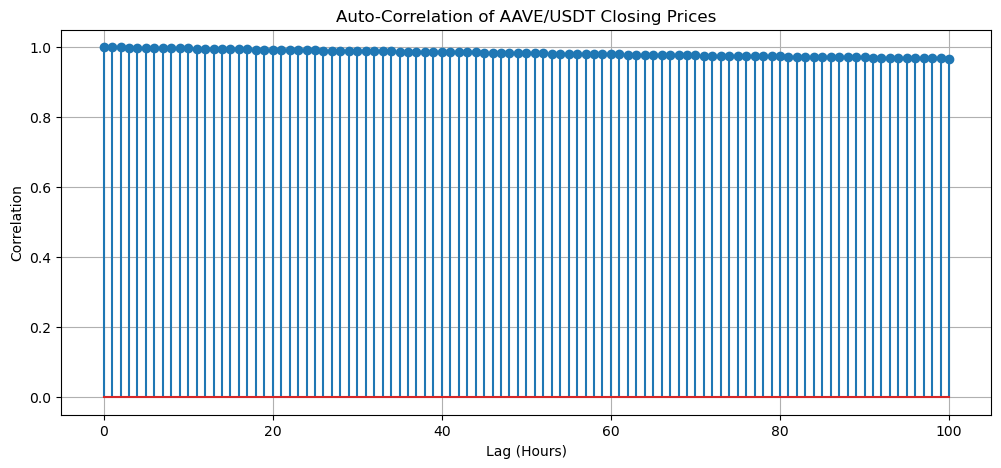

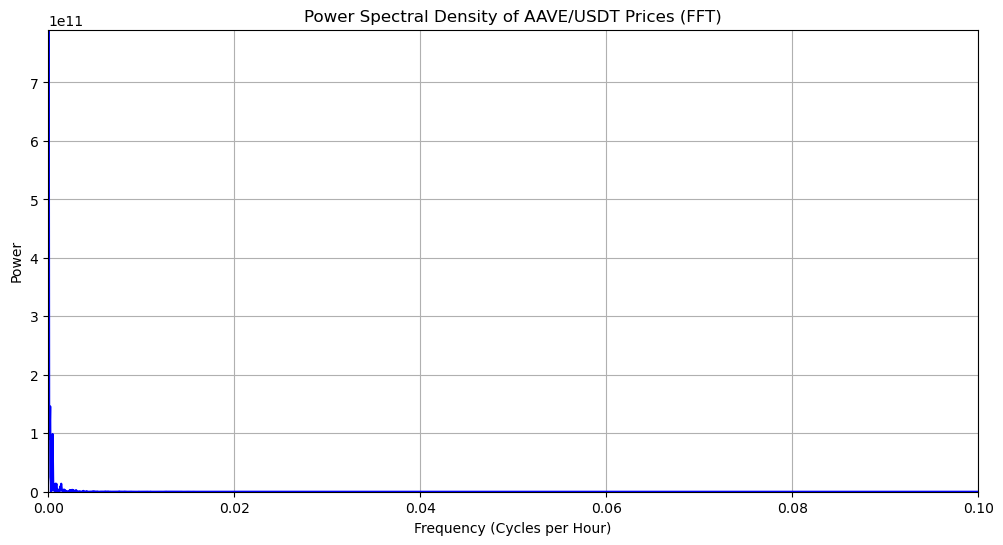

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from statsmodels.tsa.stattools import acf

# ======= Step 1: Load the Processed Dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct path
df = pd.read_csv(file_path)

# Convert timestamp back to datetime (if needed)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ======= Step 2: Compute Auto-Correlation Function (ACF) =======
prices = df["close"].values
acf_values = acf(prices, nlags=100, fft=True)  # Compute ACF with 100 lags

# ======= Step 3: Plot Auto-Correlation Function =======
plt.figure(figsize=(12, 5))
plt.stem(range(len(acf_values)), acf_values)  # Removed `use_line_collection`
plt.title("Auto-Correlation of AAVE/USDT Closing Prices")
plt.xlabel("Lag (Hours)")
plt.ylabel("Correlation")
plt.grid()
plt.show()

# ======= Step 4: Preprocess Prices for FFT (Remove DC Component) =======
prices = prices - np.mean(prices)  # Subtract mean to remove DC component

# ======= Step 5: Apply FFT =======
fft_result = fft(prices)  # Compute FFT
frequencies = fftfreq(len(prices), d=1)  # Frequency bins (1-hour intervals)

# Compute Power Spectral Density (PSD)
psd = np.abs(fft_result) ** 2  # Square of magnitudes to get power

# Take only the positive half of frequencies
positive_frequencies = frequencies[:len(frequencies)//2]
positive_psd = psd[:len(psd)//2]

# ======= Step 6: Plot Power Spectral Density (PSD) =======
plt.figure(figsize=(12, 6))
plt.plot(positive_frequencies, positive_psd, color='blue')
plt.title("Power Spectral Density of AAVE/USDT Prices (FFT)")
plt.xlabel("Frequency (Cycles per Hour)")
plt.ylabel("Power")
plt.xlim([0, 0.1])  # Focus on meaningful frequency range
plt.ylim([0, np.max(positive_psd) * 0.2])  # Adjust scale for clarity
plt.grid()
plt.show()


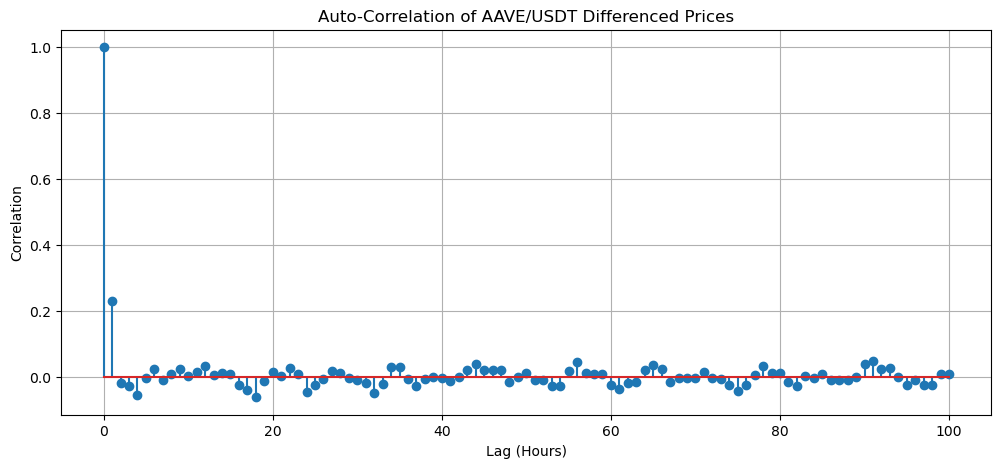

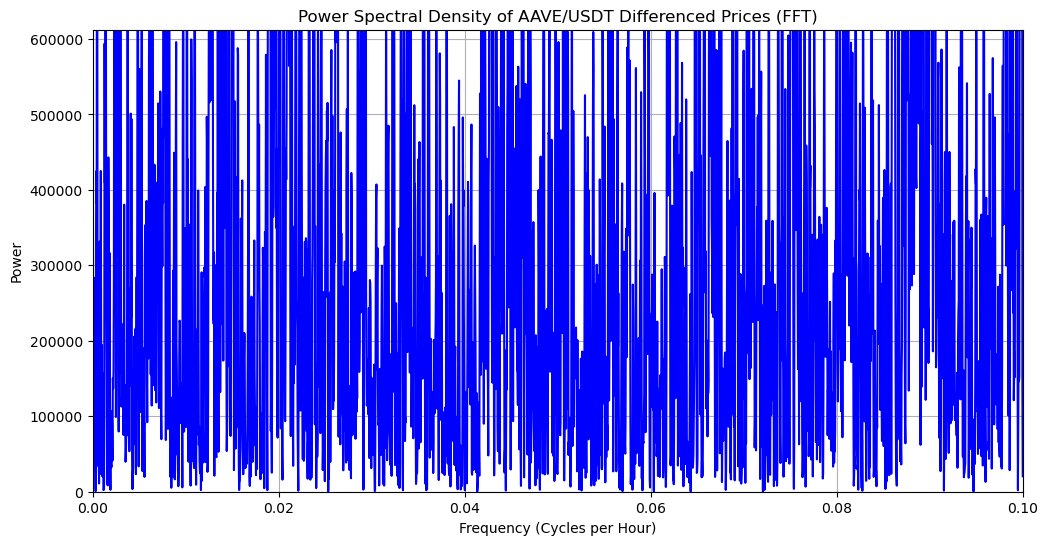

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from statsmodels.tsa.stattools import acf

# ======= Step 1: Load the Processed Dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct path
df = pd.read_csv(file_path)

# Convert timestamp back to datetime (if needed)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ======= Step 2: Apply First-Order Differencing to Remove Trend =======
df["diff_close"] = df["close"].diff().dropna()

# Drop NaN values from differencing
df = df.dropna()

# Extract differenced closing prices
prices = df["diff_close"].values

# ======= Step 3: Compute Auto-Correlation Function (ACF) =======
acf_values = acf(prices, nlags=100, fft=True)  # Compute ACF with 100 lags

# ======= Step 4: Plot Auto-Correlation Function =======
plt.figure(figsize=(12, 5))
plt.stem(range(len(acf_values)), acf_values)
plt.title("Auto-Correlation of AAVE/USDT Differenced Prices")
plt.xlabel("Lag (Hours)")
plt.ylabel("Correlation")
plt.grid()
plt.show()

# ======= Step 5: Apply FFT =======
prices = prices - np.mean(prices)  # Remove mean (DC Component)
fft_result = fft(prices)  # Compute FFT
frequencies = fftfreq(len(prices), d=1)  # Frequency bins (1-hour intervals)

# Compute Power Spectral Density (PSD)
psd = np.abs(fft_result) ** 2  # Square of magnitudes to get power

# Take only the positive half of frequencies
positive_frequencies = frequencies[:len(frequencies)//2]
positive_psd = psd[:len(psd)//2]

# ======= Step 6: Plot Power Spectral Density (PSD) =======
plt.figure(figsize=(12, 6))
plt.plot(positive_frequencies, positive_psd, color='blue')
plt.title("Power Spectral Density of AAVE/USDT Differenced Prices (FFT)")
plt.xlabel("Frequency (Cycles per Hour)")
plt.ylabel("Power")
plt.xlim([0, 0.1])  # Focus on meaningful frequency range
plt.ylim([0, np.max(positive_psd) * 0.2])  # Adjust scale for clarity
plt.grid()
plt.show()


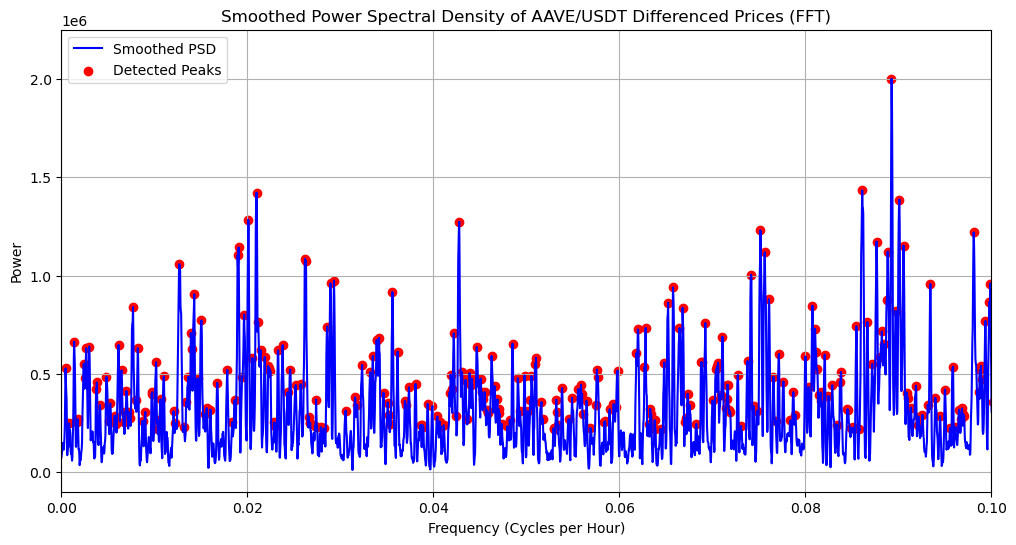

Identified Trading Cycles (in Hours): [2.25200000e+03 1.17495652e+03 7.30378378e+02 ... 2.02124159e+00
 2.01686693e+00 2.00474777e+00]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import find_peaks

# ======= Step 1: Load the Processed Dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct path
df = pd.read_csv(file_path)

# Convert timestamp back to datetime (if needed)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ======= Step 2: Apply First-Order Differencing =======
df["diff_close"] = df["close"].diff().dropna()
df = df.dropna()

# Extract differenced closing prices
prices = df["diff_close"].values

# ======= Step 3: Apply FFT =======
prices = prices - np.mean(prices)  # Remove mean (DC Component)
fft_result = fft(prices)  # Compute FFT
frequencies = fftfreq(len(prices), d=1)  # Frequency bins (1-hour intervals)

# Compute Power Spectral Density (PSD)
psd = np.abs(fft_result) ** 2  # Square of magnitudes to get power

# Take only the positive half of frequencies
positive_frequencies = frequencies[:len(frequencies)//2]
positive_psd = psd[:len(psd)//2]

# ======= Step 4: Smooth the PSD (Moving Average) =======
window_size = 5  # Adjust this for more or less smoothing
smoothed_psd = np.convolve(positive_psd, np.ones(window_size)/window_size, mode='same')

# ======= Step 5: Find Peaks in the FFT Spectrum =======
peaks, _ = find_peaks(smoothed_psd, height=np.max(smoothed_psd) * 0.1)  # Detect strong peaks

# Convert Frequency to Time Period
dominant_frequencies = positive_frequencies[peaks]
dominant_periods = 1 / dominant_frequencies  # Convert cycles per hour to hours

# ======= Step 6: Plot Smoothed Power Spectral Density (PSD) =======
plt.figure(figsize=(12, 6))
plt.plot(positive_frequencies, smoothed_psd, color='blue', label="Smoothed PSD")
plt.scatter(dominant_frequencies, smoothed_psd[peaks], color='red', label="Detected Peaks")
plt.title("Smoothed Power Spectral Density of AAVE/USDT Differenced Prices (FFT)")
plt.xlabel("Frequency (Cycles per Hour)")
plt.ylabel("Power")
plt.xlim([0, 0.1])  # Focus on meaningful frequency range
plt.legend()
plt.grid()
plt.show()

# ======= Step 7: Print Identified Cycles =======
print("Identified Trading Cycles (in Hours):", dominant_periods)


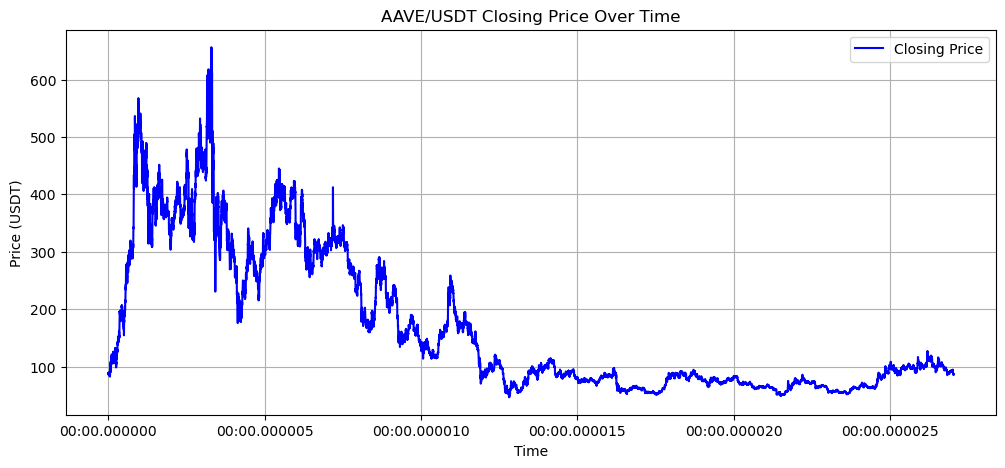

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ======= Step 1: Load the Processed Dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Convert timestamp back to datetime (if needed)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ======= Step 2: Plot Closing Price Over Time =======
plt.figure(figsize=(12, 5))
plt.plot(df["timestamp"], df["close"], color='blue', label="Closing Price")
plt.xlabel("Time")
plt.ylabel("Price (USDT)")
plt.title("AAVE/USDT Closing Price Over Time")
plt.legend()
plt.grid()
plt.show()


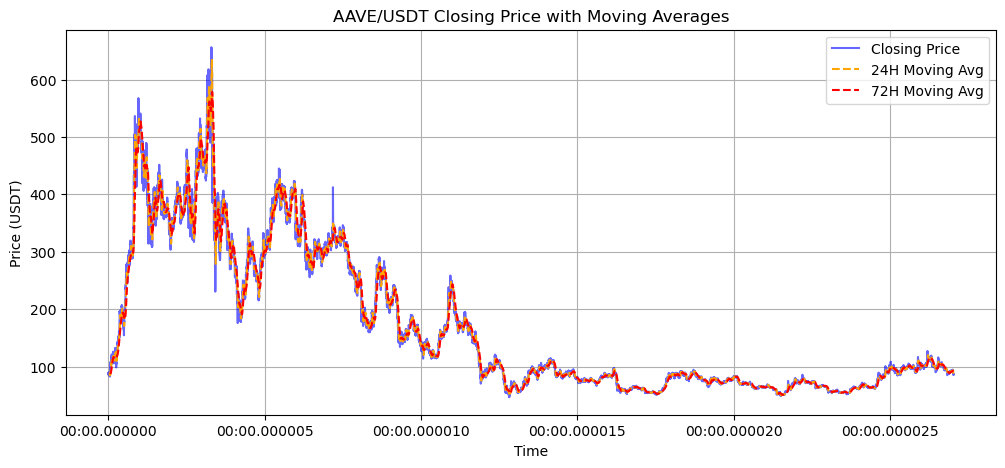

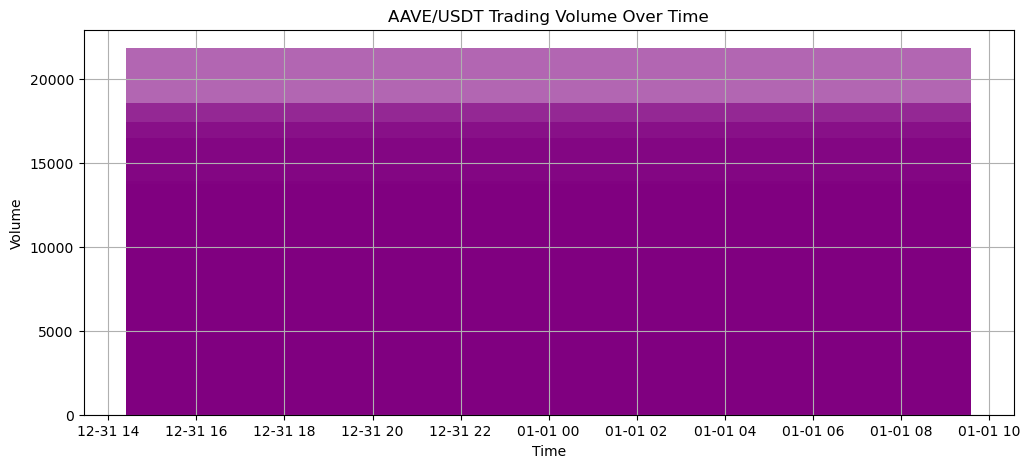

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ======= Step 1: Load the Processed Dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Convert timestamp back to datetime (if needed)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ======= Step 2: Compute Moving Averages =======
df["MA_24"] = df["close"].rolling(window=24).mean()  # 24-hour moving average
df["MA_72"] = df["close"].rolling(window=72).mean()  # 72-hour moving average

# ======= Step 3: Plot Closing Price with Moving Averages =======
plt.figure(figsize=(12, 5))
plt.plot(df["timestamp"], df["close"], color='blue', label="Closing Price", alpha=0.6)
plt.plot(df["timestamp"], df["MA_24"], color='orange', label="24H Moving Avg", linestyle="--")
plt.plot(df["timestamp"], df["MA_72"], color='red', label="72H Moving Avg", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Price (USDT)")
plt.title("AAVE/USDT Closing Price with Moving Averages")
plt.legend()
plt.grid()
plt.show()

# ======= Step 4: Plot Trading Volume Over Time =======
plt.figure(figsize=(12, 5))
plt.bar(df["timestamp"], df["volume"], color='purple', alpha=0.6)
plt.xlabel("Time")
plt.ylabel("Volume")
plt.title("AAVE/USDT Trading Volume Over Time")
plt.grid()
plt.show()


        open       high        low      close      volume      quote_av  \
0  87.078183  87.193517  86.973133  87.065483  482.811667  42044.680132   
1  87.821200  87.932133  87.710800  87.803767  391.631667  34421.372993   
2  87.154383  87.249100  87.069367  87.157650  227.720000  19844.127042   
3  88.421717  88.526850  88.346933  88.426200  229.650000  20324.513678   
4  88.172167  88.270083  88.071517  88.162767  270.246667  23880.126850   

      trades  tb_base_av   tb_quote_av                      timestamp  
0  98.200000  228.996667  19958.955470  1970-01-01 00:00:00.000000000  
1  85.316667  170.961667  15040.955652  1970-01-01 00:00:00.000000001  
2  62.583333  105.726667   9219.294343  1970-01-01 00:00:00.000000002  
3  64.050000  101.183333   8954.714327  1970-01-01 00:00:00.000000003  
4  69.233333  103.030000   9117.159793  1970-01-01 00:00:00.000000004  
0   1970-01-01 00:00:00.000000000
1   1970-01-01 00:00:00.000000001
2   1970-01-01 00:00:00.000000002
3   1970-01-01 

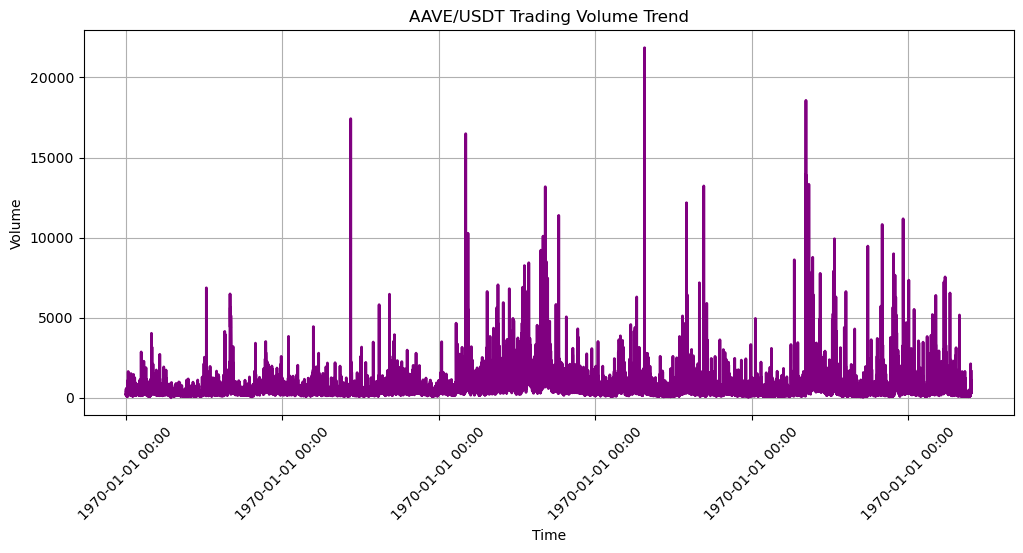

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load dataset
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct path
df = pd.read_csv(file_path)

# Check first few rows to verify timestamp format
print(df.head())

# Fix: Convert timestamp properly
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')  # Ensure correct datetime format

# Verify correct parsing
print(df["timestamp"].head())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot Trading Volume with Correct Time Format
ax.plot(df["timestamp"], df["volume"], color='purple', linewidth=2)

# Fix: Properly format x-axis labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Correct format
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjusts tick spacing

plt.xlabel("Time")
plt.ylabel("Volume")
plt.title("AAVE/USDT Trading Volume Trend")
plt.xticks(rotation=45)  # Rotate for readability
plt.grid()
plt.show()


In [8]:
import numpy as np

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Compute log time difference
df["log_time_diff"] = np.log1p((df["timestamp"] - df["timestamp"].min()).dt.total_seconds())

# Use `log_time_diff` as the new x-axis in plots


In [9]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter for smoothing
psd_smoothed = savgol_filter(psd, window_length=11, polyorder=2)


In [10]:
from scipy.stats import norm

# Compute a null distribution for PSD noise
null_mean = np.mean(psd)
null_std = np.std(psd)

# Set threshold for significant peaks (e.g., 2 standard deviations above mean)
threshold = null_mean + 2 * null_std

# Detect peaks that exceed the null threshold
significant_peaks = frequencies[psd > threshold]


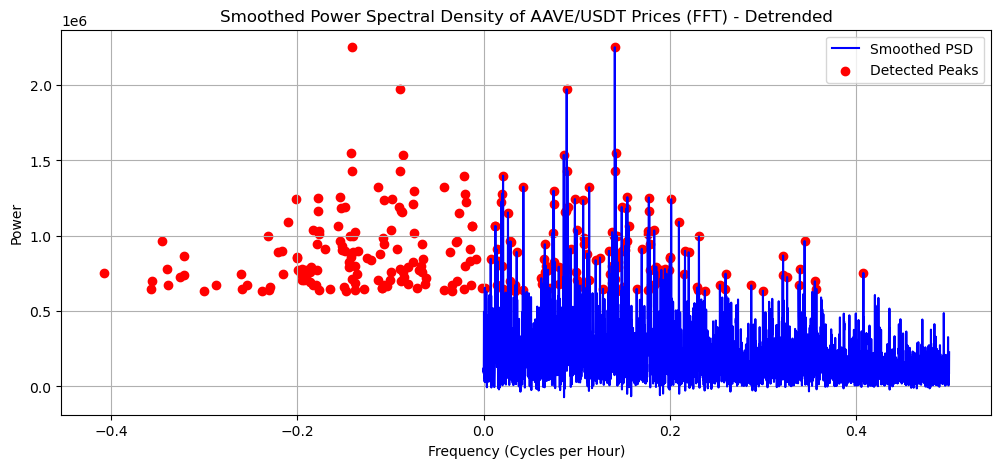

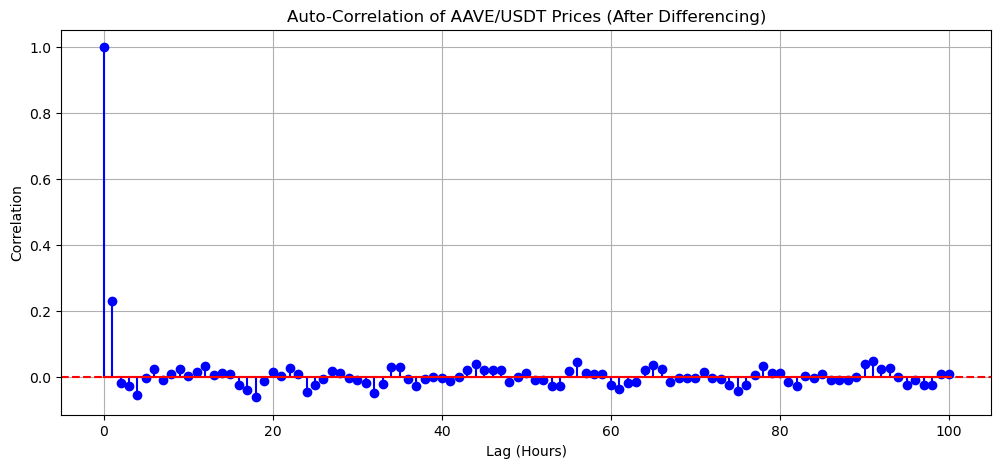

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from statsmodels.tsa.stattools import acf

# ======= Load dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct file path
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')

# ======= Apply Differencing to Make Data Stationary =======
df["close_diff"] = df["close"].diff().dropna()  # First-order differencing

# Remove mean from differenced data
closing_prices = df["close_diff"].dropna().values
closing_prices = closing_prices - np.mean(closing_prices)  # Remove bias

# ======= Compute FFT on Detrended Data =======
frequencies = np.fft.fftfreq(len(closing_prices))
psd = np.abs(np.fft.fft(closing_prices)) ** 2  # Power Spectral Density

# ======= Apply Smoothing to FFT Spectrum =======
psd_smoothed = savgol_filter(psd, window_length=11, polyorder=2)

# ======= Compute Null Distribution for Peak Detection =======
null_mean = np.mean(psd_smoothed)
null_std = np.std(psd_smoothed)
threshold = null_mean + 2 * null_std  # 2 standard deviations above mean

# Detect statistically significant peaks
peaks, _ = find_peaks(psd_smoothed, height=threshold)

# ======= Compute Auto-Correlation on Differenced Data =======
acf_values = acf(closing_prices, nlags=100)

# ======= Plot 1: Smoothed FFT Power Spectrum =======
plt.figure(figsize=(12, 5))
plt.plot(frequencies[:len(frequencies) // 2], psd_smoothed[:len(frequencies) // 2], color='blue', label="Smoothed PSD")
plt.scatter(frequencies[peaks], psd_smoothed[peaks], color='red', label="Detected Peaks")
plt.xlabel("Frequency (Cycles per Hour)")
plt.ylabel("Power")
plt.title("Smoothed Power Spectral Density of AAVE/USDT Prices (FFT) - Detrended")
plt.legend()
plt.grid()
plt.show()

# ======= Plot 2: Auto-Correlation Function (Fixed) =======
plt.figure(figsize=(12, 5))
plt.stem(range(len(acf_values)), acf_values, basefmt="r-", markerfmt="bo", linefmt="b-")  # Fixed plotting issue
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Lag (Hours)")
plt.ylabel("Correlation")
plt.title("Auto-Correlation of AAVE/USDT Prices (After Differencing)")
plt.grid()
plt.show()


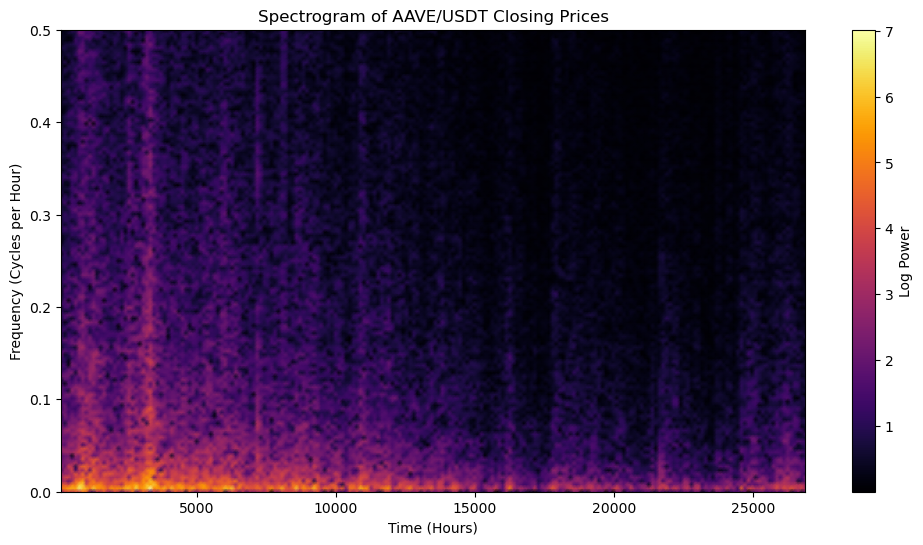

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# ======= Load dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Update with correct file path
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')

# Extract the closing prices
closing_prices = df["close"].dropna().values

# Remove mean to eliminate DC component
closing_prices = closing_prices - np.mean(closing_prices)

# ======= Compute Spectrogram =======
fs = 1  # Assuming 1 observation per hour
frequencies, times, Sxx = spectrogram(closing_prices, fs=fs, nperseg=256, noverlap=128, scaling='density', mode='magnitude')

# ======= Plot Spectrogram =======
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, np.log1p(Sxx), shading='gouraud', cmap='inferno')
plt.colorbar(label="Log Power")
plt.xlabel("Time (Hours)")
plt.ylabel("Frequency (Cycles per Hour)")
plt.title("Spectrogram of AAVE/USDT Closing Prices")
plt.show()


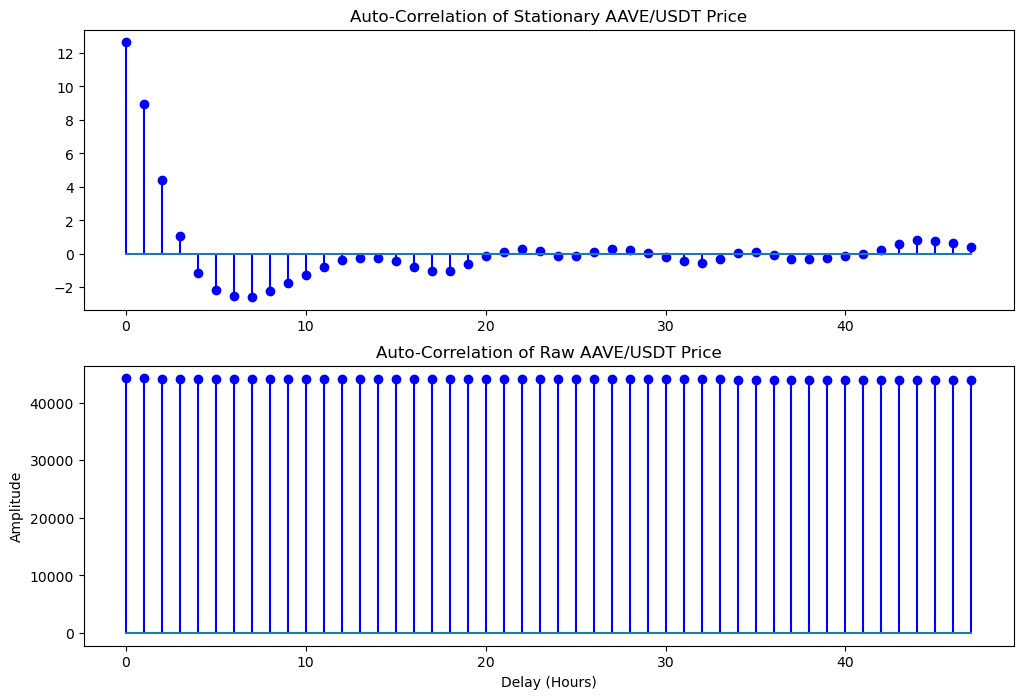

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# ======= Load dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct file path
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')

# Extract the closing prices
price = df["close"].dropna().values

# ======= 1️⃣ Compute Auto-Correlation Function (ACF) in PyTorch =======
def autocorr(input_tensor, delay):
    """ Compute auto-correlation for a given delay. """
    input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
    input_delayed = torch.roll(input_tensor, shifts=delay, dims=0)
    return torch.dot(input_tensor, input_delayed).item() / len(input_tensor)

# Compute Gaussian-filtered stationary price (from previous step)
filter_width = 12

def gaussian_kernel_1d(filter_width):
    sigma = (filter_width) / 2.33  # 99% of the values within this range
    norm = 1.0 / (np.sqrt(2*np.pi) * sigma)
    kernel = [norm * np.exp((-1)*(x**2)/(2 * sigma**2)) for x in range(-filter_width, filter_width + 1)]
    kernel = np.array(kernel, dtype=np.float32)
    return kernel / np.sum(kernel)  # Normalize

# Convert price data to PyTorch tensor
price_tensor = torch.tensor(price, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, T]

# Create Gaussian kernel
gaussian_kernel = torch.tensor(gaussian_kernel_1d(filter_width), dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Apply 1D convolution using PyTorch
filtered_price = torch.nn.functional.conv1d(price_tensor, gaussian_kernel, padding='same').squeeze().numpy()

# Compute zero-centered stationary price
price_centered = price - filtered_price

# ======= 2️⃣ Compute ACF for Raw and Stationary Data =======
delays = np.arange(0, 48)  # Delays up to 2 days (in hours)

# Compute auto-correlation for raw price
autocorr_price = [autocorr(price, hour) for hour in delays]

# Compute auto-correlation for stationary (filtered) price
autocorr_centered_price = [autocorr(price_centered, hour) for hour in delays]

# ======= 3️⃣ Plot Auto-Correlation Comparisons =======
fig, axes = plt.subplots(2, figsize=(12, 8))

# Plot ACF for stationary (filtered) price
axes[0].stem(delays, autocorr_centered_price, linefmt='b-', markerfmt='bo', basefmt='')
axes[0].set_title('Auto-Correlation of Stationary AAVE/USDT Price')

# Plot ACF for raw price
axes[1].stem(delays, autocorr_price, linefmt='b-', markerfmt='bo', basefmt='')
axes[1].set_title('Auto-Correlation of Raw AAVE/USDT Price')
axes[1].set(xlabel='Delay (Hours)', ylabel='Amplitude')

plt.show()


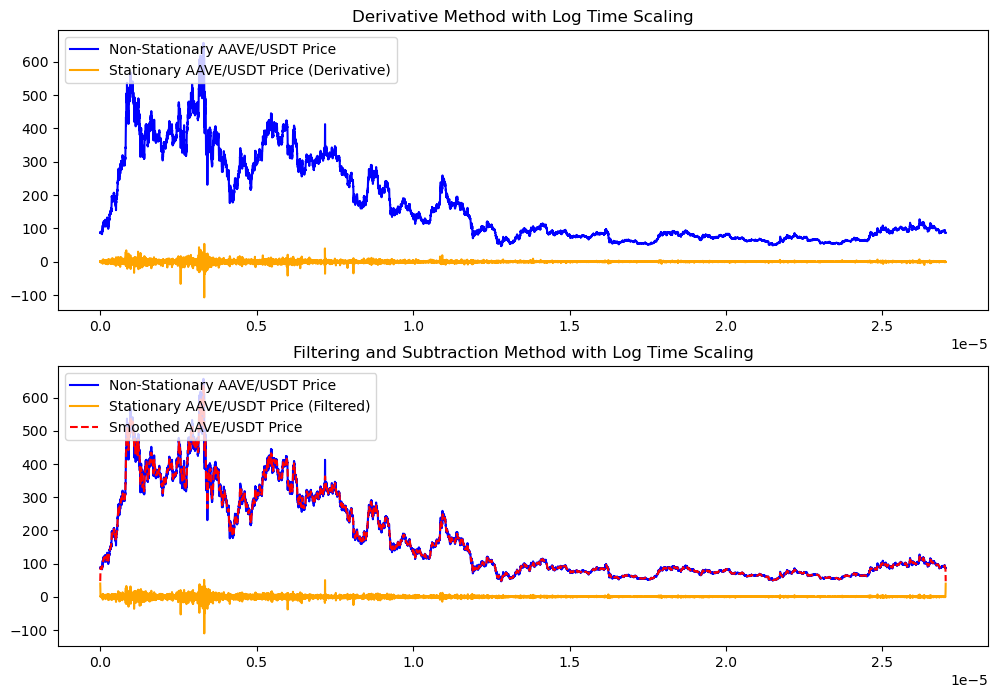

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ======= Load dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct file path
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')

# Compute log time difference
df["log_time_diff"] = np.log1p((df["timestamp"] - df["timestamp"].min()).dt.total_seconds())

# Extract the closing prices
price = df["close"].dropna().values

# ======= 1️⃣ Method 1: Derivative Method (Differencing) =======
price_dt = price[1:] - price[:-1]  # First-order differencing

# ======= 2️⃣ Method 2: Gaussian Filtering Method (PyTorch) =======
filter_width = 12

def gaussian_kernel_1d(filter_width):
    sigma = (filter_width) / 2.33  # 99% of the values within this range
    norm = 1.0 / (np.sqrt(2*np.pi) * sigma)
    kernel = [norm * np.exp((-1)*(x**2)/(2 * sigma**2)) for x in range(-filter_width, filter_width + 1)]
    kernel = np.array(kernel, dtype=np.float32)
    return kernel / np.sum(kernel)  # Normalize

# Convert price data to PyTorch tensor
price_tensor = torch.tensor(price, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, T]

# Create Gaussian kernel
gaussian_kernel = torch.tensor(gaussian_kernel_1d(filter_width), dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Apply 1D convolution using PyTorch
filtered_price = F.conv1d(price_tensor, gaussian_kernel, padding='same').squeeze().numpy()

# Compute zero-centered price by subtracting the smoothed signal
price_centered = price - filtered_price

# Create time-shifted array for plotting (using log time difference)
time_shifted_log = df["log_time_diff"].iloc[1:].values  # Shift to match differenced data length

# ======= Plot Comparison with Log Time Difference =======
fig, axes = plt.subplots(2, figsize=(12, 8))

# Plot 1: Derivative Method
axes[0].plot(time_shifted_log, price[:-1], label="Non-Stationary AAVE/USDT Price", color='blue')
axes[0].plot(time_shifted_log, price_dt, label="Stationary AAVE/USDT Price (Derivative)", color='orange')
axes[0].set_title('Derivative Method with Log Time Scaling')
axes[0].legend(loc="upper left")

# Plot 2: Gaussian Filtering & Subtraction Method
axes[1].plot(df["log_time_diff"], price, label="Non-Stationary AAVE/USDT Price", color='blue')
axes[1].plot(df["log_time_diff"], price_centered, label="Stationary AAVE/USDT Price (Filtered)", color='orange')
axes[1].plot(df["log_time_diff"], filtered_price, label="Smoothed AAVE/USDT Price", color='red', linestyle="--")
axes[1].set_title('Filtering and Subtraction Method with Log Time Scaling')
axes[1].legend(loc="upper left")

plt.show()


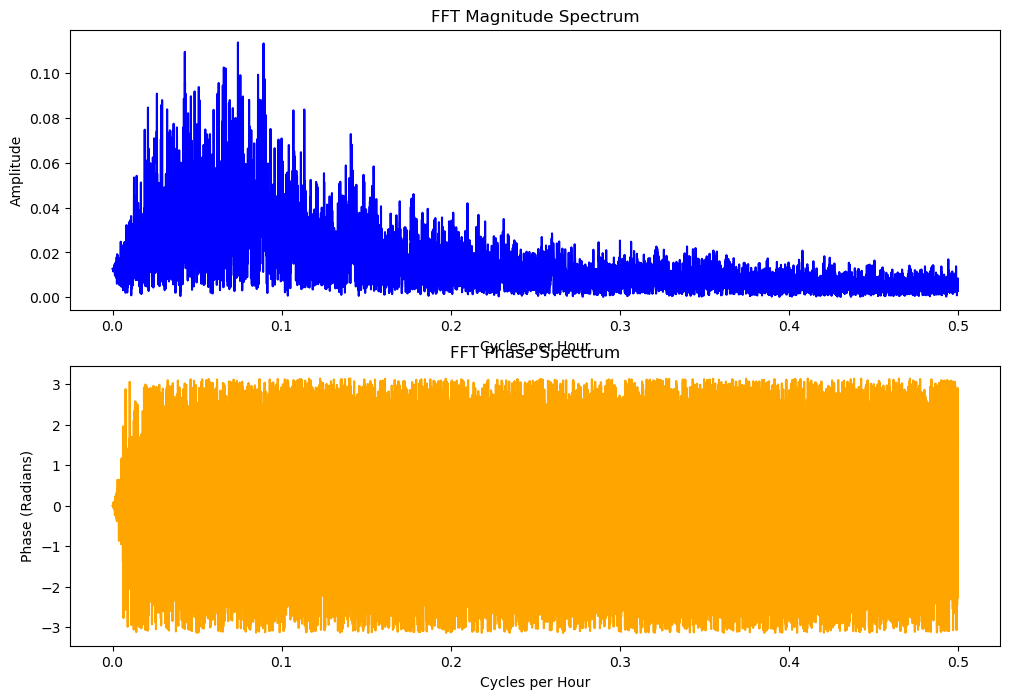

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# ======= Load dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct file path
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')

# Extract the closing prices
price = df["close"].dropna().values

# ======= 1️⃣ Compute Gaussian-Filtered Stationary Price =======
filter_width = 12

def gaussian_kernel_1d(filter_width):
    sigma = (filter_width) / 2.33  # 99% of the values within this range
    norm = 1.0 / (np.sqrt(2*np.pi) * sigma)
    kernel = [norm * np.exp((-1)*(x**2)/(2 * sigma**2)) for x in range(-filter_width, filter_width + 1)]
    kernel = np.array(kernel, dtype=np.float32)
    return kernel / np.sum(kernel)  # Normalize

# Convert price data to PyTorch tensor
price_tensor = torch.tensor(price, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, T]

# Create Gaussian kernel
gaussian_kernel = torch.tensor(gaussian_kernel_1d(filter_width), dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Apply 1D convolution using PyTorch
filtered_price = torch.nn.functional.conv1d(price_tensor, gaussian_kernel, padding='same').squeeze().numpy()

# Compute zero-centered stationary price
price_centered = price - filtered_price

# ======= 2️⃣ Compute FFT =======
price_tensor_centered = torch.tensor(price_centered, dtype=torch.float32)
price_fourier = torch.fft.fft(price_tensor_centered)  # FFT on stationary data

T = 1  # Sampling interval in hours (since data is hourly)
N = price_fourier.shape[0]
frequencies = np.fft.fftfreq(N, d=T)  # Frequency in cycles per hour

# Compute Magnitude and Phase
magnitude = torch.abs(price_fourier).numpy() * (1 / N)  # Normalize magnitude
phase = torch.angle(price_fourier).numpy()  # Phase component

# ======= 3️⃣ Plot FFT Magnitude & Phase =======
fig, axes = plt.subplots(2, figsize=(12, 8))

# Plot FFT Magnitude Spectrum
axes[0].plot(frequencies[:N // 2], magnitude[:N // 2], color='blue')
axes[0].set_title('FFT Magnitude Spectrum')
axes[0].set_xlabel("Cycles per Hour")
axes[0].set_ylabel("Amplitude")

# Plot FFT Phase Spectrum
axes[1].plot(frequencies[:N // 2], phase[:N // 2], color='orange')
axes[1].set_title('FFT Phase Spectrum')
axes[1].set_xlabel("Cycles per Hour")
axes[1].set_ylabel("Phase (Radians)")

plt.show()


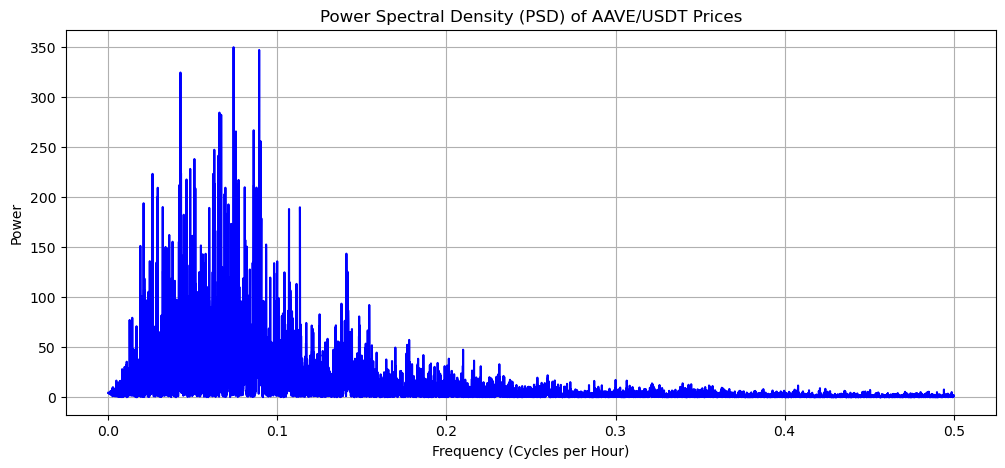

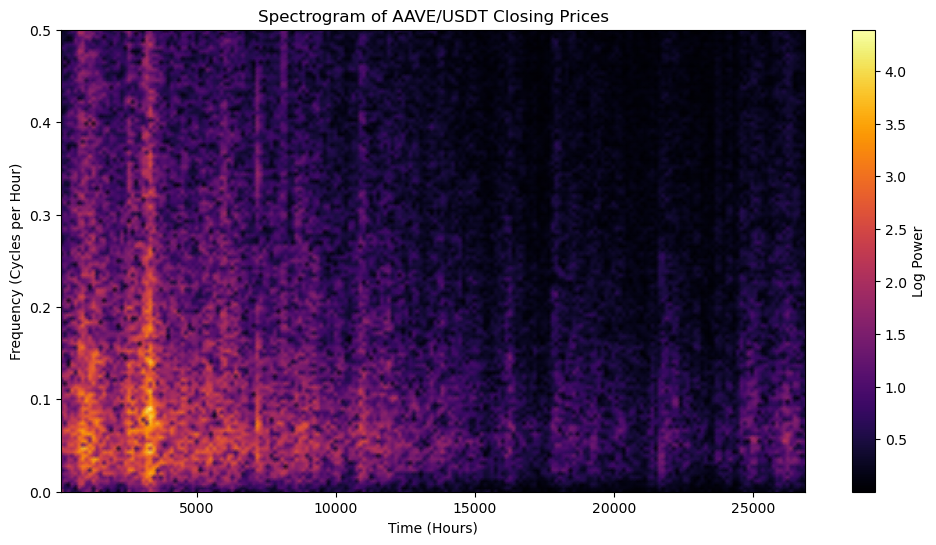

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.signal import spectrogram

# ======= Load dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct file path
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')

# Extract the closing prices
price = df["close"].dropna().values

# ======= 1️⃣ Compute Gaussian-Filtered Stationary Price =======
filter_width = 12

def gaussian_kernel_1d(filter_width):
    sigma = (filter_width) / 2.33  # 99% of the values within this range
    norm = 1.0 / (np.sqrt(2*np.pi) * sigma)
    kernel = [norm * np.exp((-1)*(x**2)/(2 * sigma**2)) for x in range(-filter_width, filter_width + 1)]
    kernel = np.array(kernel, dtype=np.float32)
    return kernel / np.sum(kernel)  # Normalize

# Convert price data to PyTorch tensor
price_tensor = torch.tensor(price, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, T]

# Create Gaussian kernel
gaussian_kernel = torch.tensor(gaussian_kernel_1d(filter_width), dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Apply 1D convolution using PyTorch
filtered_price = torch.nn.functional.conv1d(price_tensor, gaussian_kernel, padding='same').squeeze().numpy()

# Compute zero-centered stationary price
price_centered = price - filtered_price

# ======= 2️⃣ Compute FFT for PSD =======
price_tensor_centered = torch.tensor(price_centered, dtype=torch.float32)
price_fourier = torch.fft.fft(price_tensor_centered)  # FFT on stationary data

T = 1  # Sampling interval in hours
N = price_fourier.shape[0]
frequencies = np.fft.fftfreq(N, d=T)  # Frequency in cycles per hour

# Compute Power Spectral Density (PSD)
psd = (torch.abs(price_fourier) ** 2).numpy() * (1 / N)  # Normalize power

# ======= 3️⃣ Compute Spectrogram =======
fs = 1  # 1 sample per hour
freqs, times, Sxx = spectrogram(price_centered, fs=fs, nperseg=256, noverlap=128, scaling='density', mode='magnitude')

# ======= 4️⃣ Plot PSD =======
plt.figure(figsize=(12, 5))
plt.plot(frequencies[:N // 2], psd[:N // 2], color='blue')
plt.title("Power Spectral Density (PSD) of AAVE/USDT Prices")
plt.xlabel("Frequency (Cycles per Hour)")
plt.ylabel("Power")
plt.grid()
plt.show()

# ======= 5️⃣ Plot Spectrogram =======
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, freqs, np.log1p(Sxx), shading='gouraud', cmap='inferno')
plt.colorbar(label="Log Power")
plt.xlabel("Time (Hours)")
plt.ylabel("Frequency (Cycles per Hour)")
plt.title("Spectrogram of AAVE/USDT Closing Prices")
plt.show()


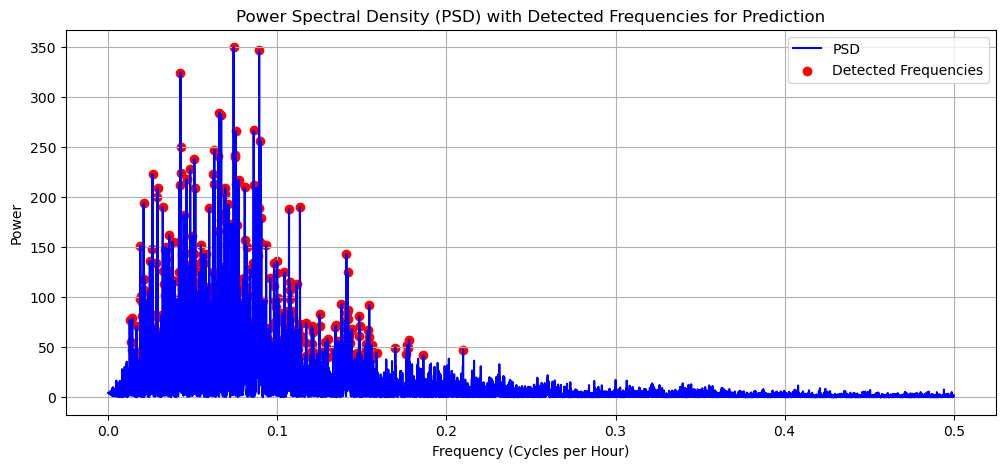

Detected Frequencies (Cycles per Hour): [0.01269195 0.01361702 0.01387604 0.01398705 0.01424607 0.01513414
 0.01609621 0.01676226 0.01887142 0.01901943 0.01909343 0.01935245
 0.01968548 0.0200555  0.02016651 0.02057354 0.02079556 0.02094357
 0.02120259 0.02142461 0.02168363 0.02183164 0.02227567 0.02242368
 0.0226827  0.02305273 0.02327475 0.02375578 0.02382979 0.0239408
 0.02427382 0.02438483 0.02460685 0.02471785 0.02501388 0.0252729
 0.02549491 0.02564292 0.02582794 0.02612396 0.02623497 0.02638298
 0.026679   0.02675301 0.02686401 0.02712303 0.02730805 0.02745606
 0.02786309 0.02812211 0.02856614 0.02878816 0.02897317 0.02904718
 0.0293062  0.02989824 0.03045328 0.03052729 0.0306383  0.03115634
 0.03145236 0.03156337 0.03163737 0.03178538 0.03226642 0.03241443
 0.03296947 0.03315449 0.03326549 0.03348751 0.03382054 0.03393154
 0.03404255 0.03419056 0.03437558 0.03459759 0.0346716  0.03504163
 0.03515264 0.03533765 0.03555967 0.03567068 0.03585569 0.03611471
 0.03618871 0.03685476 0

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.signal import find_peaks

# ======= Load dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')

# Extract the closing prices
price = df["close"].dropna().values

# ======= 1️⃣ Compute Gaussian-Filtered Stationary Price =======
filter_width = 12

def gaussian_kernel_1d(filter_width):
    sigma = (filter_width) / 2.33  # 99% of the values within this range
    norm = 1.0 / (np.sqrt(2*np.pi) * sigma)
    kernel = [norm * np.exp((-1)*(x**2)/(2 * sigma**2)) for x in range(-filter_width, filter_width + 1)]
    kernel = np.array(kernel, dtype=np.float32)
    return kernel / np.sum(kernel)  # Normalize

# Convert price data to PyTorch tensor
price_tensor = torch.tensor(price, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, T]

# Create Gaussian kernel
gaussian_kernel = torch.tensor(gaussian_kernel_1d(filter_width), dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Apply 1D convolution using PyTorch
filtered_price = torch.nn.functional.conv1d(price_tensor, gaussian_kernel, padding='same').squeeze().numpy()

# Compute zero-centered stationary price
price_centered = price - filtered_price

# ======= 2️⃣ Compute FFT for PSD =======
price_tensor_centered = torch.tensor(price_centered, dtype=torch.float32)
price_fourier = torch.fft.fft(price_tensor_centered)  # FFT on stationary data

T = 1  # Sampling interval in hours
N = price_fourier.shape[0]
frequencies = np.fft.fftfreq(N, d=T)  # Frequency in cycles per hour

# Compute Power Spectral Density (PSD)
psd = (torch.abs(price_fourier) ** 2).numpy() * (1 / N)  # Normalize power

# ======= 3️⃣ Detect Peaks in PSD =======
peaks, _ = find_peaks(psd[:N // 2], height=np.mean(psd) + np.std(psd))  # Threshold at mean + 1 std

# ======= 4️⃣ Plot PSD with Detected Frequencies =======
plt.figure(figsize=(12, 5))
plt.plot(frequencies[:N // 2], psd[:N // 2], color='blue', label="PSD")
plt.scatter(frequencies[peaks], psd[peaks], color='red', label="Detected Frequencies")
plt.title("Power Spectral Density (PSD) with Detected Frequencies for Prediction")
plt.xlabel("Frequency (Cycles per Hour)")
plt.ylabel("Power")
plt.legend()
plt.grid()
plt.show()

# Print the detected key frequencies for prediction
detected_frequencies = frequencies[peaks]
print("Detected Frequencies (Cycles per Hour):", detected_frequencies)



📊 Correlation with 'close':
 open           1.000000
high           0.999998
low            0.999998
close          1.000000
volume        -0.102811
quote_av       0.387039
trades         0.154495
tb_base_av    -0.108771
tb_quote_av    0.373413
Name: close, dtype: float64

📊 Ridge Regression (Time-based Split) Performance:
   - R² Score: 1.0000
   - RMSE: 0.0257
   - MAE: 0.0213


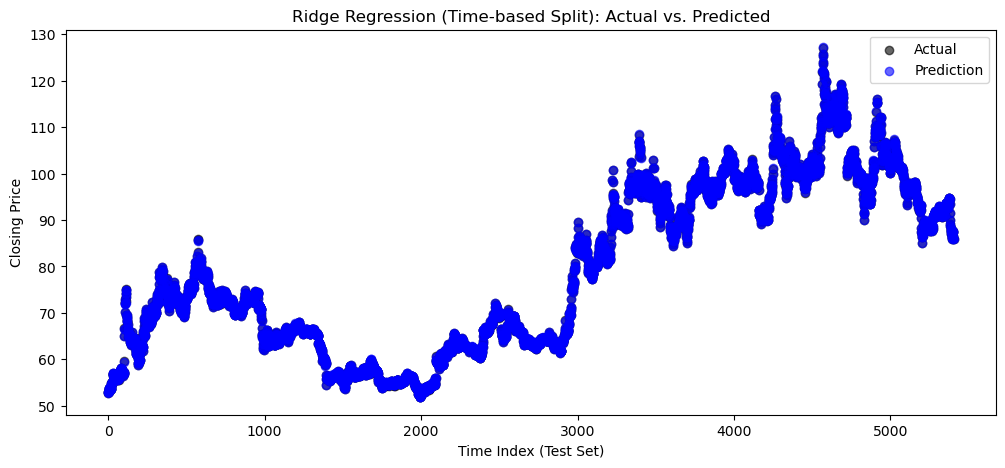

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# ======= Load Dataset =======
file_path = "processed_AAVEUSDT_hourly.csv"  # Update path if needed
df = pd.read_csv(file_path)

# 1. Sort by timestamp if available
# If you have no timestamp, skip this step or rename to correct column
#df = df.sort_values("timestamp")

# 2. Correlation Analysis
corr_matrix = df.corr()
print("\n📊 Correlation with 'close':\n", corr_matrix["close"])

# Example: remove 'open' if correlation is extremely high
# df.drop(columns=["open"], inplace=True)  # if you find it near 1.0 correlation

# 3. Feature Selection
market_features = ["open","high","low","volume","quote_av","trades","tb_base_av","tb_quote_av"]
available_features = [col for col in market_features if col in df.columns]

X = df[available_features].ffill()  # Fill missing
y = df["close"].ffill()

# 4. Apply Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Time-based Split (80% train, 20% test)
split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 6. Ridge Regression
regression_model = Ridge(alpha=10.0)
regression_model.fit(X_train, y_train)

y_pred = regression_model.predict(X_test)

# 7. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Ridge Regression (Time-based Split) Performance:")
print(f"   - R² Score: {r2:.4f}")
print(f"   - RMSE: {rmse:.4f}")
print(f"   - MAE: {mae:.4f}")

# 8. Plot
plt.figure(figsize=(12,5))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.6, color='black')
plt.scatter(range(len(y_pred)), y_pred, label="Prediction", alpha=0.6, color='blue')
plt.legend()
plt.title("Ridge Regression (Time-based Split): Actual vs. Predicted")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Closing Price")
plt.show()


In [20]:
import requests
import pandas as pd

# Define time range: from February 1, 2023 to February 10, 2023
start_date = "2025-02-01"
end_date = "2025-02-10"

# Convert to Unix timestamps in seconds
start_timestamp = int(pd.Timestamp(start_date).timestamp())
end_timestamp = int(pd.Timestamp(end_date).timestamp())

# CoinGecko API endpoint for market chart range data
url = "https://api.coingecko.com/api/v3/coins/aave/market_chart/range"

# Define parameters: vs_currency as usd, from and to timestamps
params = {
    "vs_currency": "usd",
    "from": start_timestamp,
    "to": end_timestamp
}

# Make the API request
response = requests.get(url, params=params)
print("Status Code:", response.status_code)

if response.status_code != 200:
    print("Error:", response.text)
else:
    data = response.json()
    if not data or "prices" not in data:
        print("No data returned. Try adjusting your parameters.")
    else:
        # Create a DataFrame from the 'prices' data
        # Each entry in 'prices' is [timestamp_in_ms, price]
        df_prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
        
        # Convert timestamp from milliseconds to datetime
        df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"], unit='ms')
        
        # Display the first few rows of the DataFrame
        print(df_prices.head())


Status Code: 200
                timestamp       price
0 2025-02-01 00:03:39.884  332.819840
1 2025-02-01 01:04:04.780  331.337853
2 2025-02-01 02:03:45.876  330.195345
3 2025-02-01 03:02:29.958  330.079187
4 2025-02-01 04:03:47.078  325.863559


In [21]:
import requests
import pandas as pd

# Define time range: from February 1, 2025 to February 10, 2025
start_date = "2025-02-01"
end_date   = "2025-02-10"

# Convert dates to Unix timestamps in seconds
start_timestamp = int(pd.Timestamp(start_date).timestamp())
end_timestamp   = int(pd.Timestamp(end_date).timestamp())

# CoinGecko API endpoint for market chart range data
url = "https://api.coingecko.com/api/v3/coins/aave/market_chart/range"

# Define parameters for the API request
params = {
    "vs_currency": "usd",
    "from": start_timestamp,
    "to": end_timestamp
}

# Make the API request
response = requests.get(url, params=params)
print("Status Code:", response.status_code)

if response.status_code != 200:
    print("Error:", response.text)
else:
    data = response.json()
    if not data or "prices" not in data:
        print("No data returned. Try adjusting your parameters.")
    else:
        # Create DataFrames for prices, market caps, and total volumes
        df_prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
        df_market_caps = pd.DataFrame(data["market_caps"], columns=["timestamp", "market_cap"])
        df_total_volumes = pd.DataFrame(data["total_volumes"], columns=["timestamp", "total_volume"])
        
        # Convert timestamp from milliseconds to datetime
        df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"], unit='ms')
        df_market_caps["timestamp"] = pd.to_datetime(df_market_caps["timestamp"], unit='ms')
        df_total_volumes["timestamp"] = pd.to_datetime(df_total_volumes["timestamp"], unit='ms')
        
        # Merge the DataFrames on the timestamp
        df_merged = pd.merge(df_prices, df_market_caps, on="timestamp", how="outer")
        df_merged = pd.merge(df_merged, df_total_volumes, on="timestamp", how="outer")
        
        # Sort the DataFrame by timestamp and reset the index
        df_merged = df_merged.sort_values("timestamp").reset_index(drop=True)
        
        # Display the first few rows of the merged DataFrame
        print(df_merged.head())
        
        # Optionally, save the DataFrame to a CSV file for further analysis
        df_merged.to_csv("AAVE_ohlcv_data.csv", index=False)


Status Code: 200
                timestamp       price    market_cap  total_volume
0 2025-02-01 00:03:39.884  332.819840  5.009661e+09  8.586597e+08
1 2025-02-01 01:04:04.780  331.337853  4.987446e+09  8.610070e+08
2 2025-02-01 02:03:45.876  330.195345  4.974029e+09  8.532744e+08
3 2025-02-01 03:02:29.958  330.079187  4.973410e+09  8.535224e+08
4 2025-02-01 04:03:47.078  325.863559  4.908443e+09  8.493544e+08


Dataset Columns: ['timestamp', 'price', 'market_cap', 'total_volume']

Baseline Regression Model Performance:
R² Score: 0.8864072149162392
RMSE: 0.007232864717063751
MAE: 0.006989203132010518


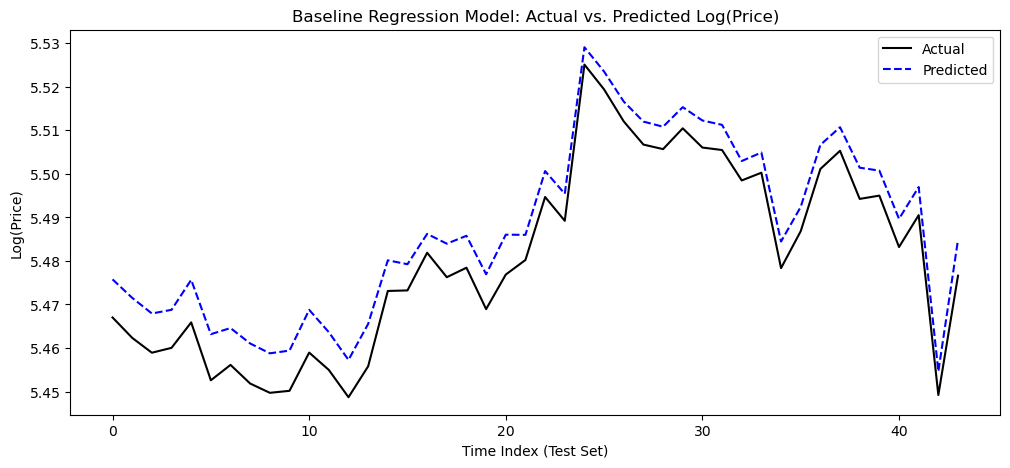

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# ======= Load Dataset =======
file_path = "AAVE_ohlcv_data.csv"  # Update with your file name/path
df = pd.read_csv(file_path)

# Inspect dataset columns
print("Dataset Columns:", df.columns.tolist())
# Expected columns: ['timestamp', 'price', 'market_cap', 'total_volume']

# ======= Convert 'timestamp' to datetime if needed =======
# If timestamps are stored as numbers (milliseconds), convert accordingly:
if np.issubdtype(df["timestamp"].dtype, np.number):
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

# ======= Log Transformation of Price and Predictors =======
# Log transform price, market_cap, and total_volume to stabilize variance
df["log_price"] = np.log(df["price"])
df["log_market_cap"] = np.log(df["market_cap"])
df["log_total_volume"] = np.log(df["total_volume"])

# ======= Define Predictors and Target =======
# We use log(market_cap) and log(total_volume) as predictors to predict log(price)
predictors = ["log_market_cap", "log_total_volume"]
X = df[predictors].ffill()  # Forward fill to handle missing values
y = df["log_price"].ffill()

# ======= Time-Based Train-Test Split =======
# Sort the dataset by time if not already sorted
df = df.sort_values("timestamp").reset_index(drop=True)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# ======= Feature Scaling =======
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======= Train a Baseline Regression Model using Ridge Regression =======
model = Ridge(alpha=14)  # Increase alpha for regularization
model.fit(X_train_scaled, y_train)

# ======= Make Predictions =======
y_pred = model.predict(X_test_scaled)

# ======= Evaluate Model Performance =======
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBaseline Regression Model Performance:")
print("R² Score:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

# ======= Plot Actual vs. Predicted Values =======
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual", color="black")
plt.plot(y_pred, label="Predicted", linestyle="--", color="blue")
plt.title("Baseline Regression Model: Actual vs. Predicted Log(Price)")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Log(Price)")
plt.legend()
plt.show()


Top 5 Frequencies (cycles/hour): [0.25581395 0.26976744 0.26046512 0.03255814 0.48372093]


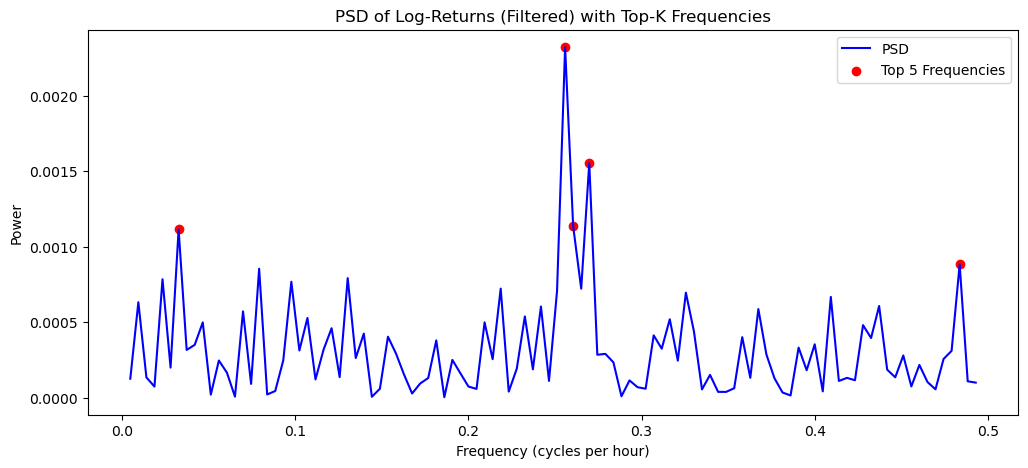

Fourier features shape: (215, 10)
Combined feature matrix shape: (215, 11)
Sequence shape: (203, 12, 11) Target shape: (203,)
Epoch [10/200], Loss: 0.001180
Epoch [20/200], Loss: 0.000476
Epoch [30/200], Loss: 0.000321
Epoch [40/200], Loss: 0.000320
Epoch [50/200], Loss: 0.000313
Epoch [60/200], Loss: 0.000301
Epoch [70/200], Loss: 0.000294
Epoch [80/200], Loss: 0.000289
Epoch [90/200], Loss: 0.000286
Epoch [100/200], Loss: 0.000284
Epoch [110/200], Loss: 0.000282
Epoch [120/200], Loss: 0.000280
Epoch [130/200], Loss: 0.000278
Epoch [140/200], Loss: 0.000276
Epoch [150/200], Loss: 0.000275
Epoch [160/200], Loss: 0.000273
Epoch [170/200], Loss: 0.000271
Epoch [180/200], Loss: 0.000270
Epoch [190/200], Loss: 0.000268
Epoch [200/200], Loss: 0.000266

Test MSE Loss (Log-Returns): 0.000199


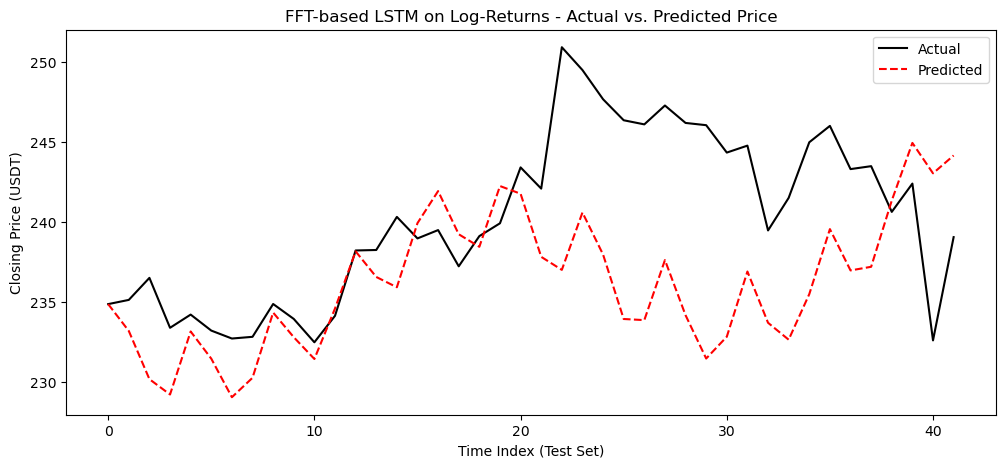

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import find_peaks

# ===============================
# 1. Load Dataset
# ===============================
file_path = "AAVE_ohlcv_data.csv"  # Adjust if needed
df = pd.read_csv(file_path)

# Convert timestamp and sort chronologically
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
df = df.sort_values("timestamp").reset_index(drop=True)

# Extract raw price
raw_price = df["price"].dropna().values
if len(raw_price) < 2:
    raise ValueError("Not enough price data for log-returns.")

# ===============================
# 2. Compute Log-Returns
# ===============================
# log_price[t] = log(raw_price[t])
# log_returns[t] = log_price[t] - log_price[t-1]
log_price = np.log(raw_price)
log_returns = np.diff(log_price)  # length N-1 if raw_price has length N
N = len(log_returns)

mean_returns = np.mean(log_returns)
stationary_returns = log_returns - mean_returns  # remove DC component if desired

# ===============================
# 3. Compute FFT & PSD on Log-Returns
# ===============================
fft_result = np.fft.fft(stationary_returns)
frequencies = np.fft.fftfreq(N, d=1)  # assuming 1-hour intervals
psd = (np.abs(fft_result) ** 2) / N

# Only positive frequencies
pos_freqs = frequencies[:N // 2]
pos_psd = psd[:N // 2]

# ===============================
# 4. Filter Out Very Low Frequencies
# ===============================
freq_threshold = 0.0005  # Example threshold, skip frequencies below this
mask = (pos_freqs > freq_threshold)
filtered_freqs = pos_freqs[mask]
filtered_psd = pos_psd[mask]

# ===============================
# 5. Select Top K Frequencies
# ===============================
K = 5
sorted_indices = np.argsort(-filtered_psd)  # sort descending
top_k_indices = sorted_indices[:K]
dominant_freqs = filtered_freqs[top_k_indices]
dominant_psd = filtered_psd[top_k_indices]

print(f"Top {K} Frequencies (cycles/hour):", dominant_freqs)

# (Optional) Plot the PSD
plt.figure(figsize=(12, 5))
plt.plot(filtered_freqs, filtered_psd, label="PSD", color="blue")
plt.scatter(dominant_freqs, dominant_psd, color="red", label=f"Top {K} Frequencies")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Power")
plt.title("PSD of Log-Returns (Filtered) with Top-K Frequencies")
plt.legend()
plt.show()

# ===============================
# 6. Create Fourier Features
# ===============================
time_indices = np.arange(N)  # 0..N-1 for log_returns
fourier_feats = []

for f in dominant_freqs:
    sin_feat = np.sin(2 * np.pi * f * time_indices)
    cos_feat = np.cos(2 * np.pi * f * time_indices)
    fourier_feats.append(sin_feat)
    fourier_feats.append(cos_feat)

if fourier_feats:
    fourier_feats = np.stack(fourier_feats, axis=1)  # shape (N, 2*K)
else:
    fourier_feats = np.zeros((N, 0))

print("Fourier features shape:", fourier_feats.shape)

# We'll also include the raw log_returns as a feature
log_returns_feat = log_returns.reshape(-1, 1)  # shape (N,1)
X_features = np.concatenate([log_returns_feat, fourier_feats], axis=1)
print("Combined feature matrix shape:", X_features.shape)

# ===============================
# 7. Create Sequences for LSTM
# ===============================
# We'll predict the next log-return: log_returns[t+1] from the past window_size steps
window_size = 12

def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i : i+window])
        y_seq.append(y[i + window])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_features, log_returns, window_size)
print("Sequence shape:", X_seq.shape, "Target shape:", y_seq.shape)

# ===============================
# 8. Time-Based Split
# ===============================
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ===============================
# 9. Define LSTM Model
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_dim = X_features.shape[1]  # (1 + 2*K)
hidden_dim = 36
num_layers = 2
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 10. Train the LSTM
# ===============================
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

# ===============================
# 11. Evaluate the Model
# ===============================
model.eval()
with torch.no_grad():
    preds_test = model(X_test_tensor)
    test_loss = criterion(preds_test, y_test_tensor).item()
    print(f"\nTest MSE Loss (Log-Returns): {test_loss:.6f}")

preds_test_np = preds_test.numpy().flatten()
y_test_np = y_test.flatten()

# ===============================
# 12. Reconstruct Price from Log-Returns
# ===============================
# We'll start from the last known log_price before the test set.
# Because log_returns[t] = log_price[t] - log_price[t-1],
# we can do a cumulative sum to get the predicted log_price sequence.

# The last train index in raw_price is (len(log_returns)), so log_price[len(log_returns)] is the final train log price
last_train_log_price = log_price[window_size + split_idx]  # approximate reference
# We'll build the predicted log_prices in the test set by cumulatively summing from that reference.

predicted_log_prices = [last_train_log_price]
for r in preds_test_np:
    next_log_price = predicted_log_prices[-1] + r
    predicted_log_prices.append(next_log_price)

# We'll do the same for actual log-returns to get the actual log_price
actual_log_prices = [last_train_log_price]
for r in y_test_np:
    next_log_price = actual_log_prices[-1] + r
    actual_log_prices.append(next_log_price)

# Convert log_prices to raw prices
preds_price = np.exp(predicted_log_prices)
actual_price = np.exp(actual_log_prices)

# Because we built these sequences cumulatively, they have length = len(preds_test) + 1
# We'll drop the first point for better alignment, or keep them as is for visualization

# ===============================
# 13. Plot Actual vs. Predicted in Original Scale
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(actual_price, label="Actual", color="black")
plt.plot(preds_price, label="Predicted", linestyle="--", color="red")
plt.title("FFT-based LSTM on Log-Returns - Actual vs. Predicted Price")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Closing Price (USDT)")
plt.legend()
plt.show()


Top 5 Frequencies (cycles/hour): [0.25581395 0.26976744 0.26046512 0.03255814 0.48372093]


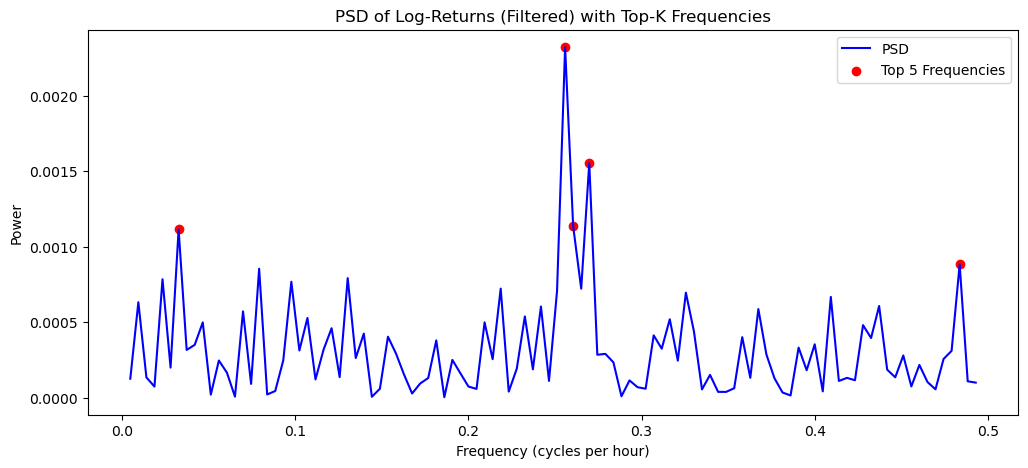

Fourier features shape: (215, 10)
Combined feature matrix shape: (215, 11)
Sequence shape: (203, 12, 11) Target shape: (203,)
Epoch [10/200], Loss: 0.000422
Epoch [20/200], Loss: 0.000350
Epoch [30/200], Loss: 0.000319
Epoch [40/200], Loss: 0.000303
Epoch [50/200], Loss: 0.000290
Epoch [60/200], Loss: 0.000281
Epoch [70/200], Loss: 0.000275
Epoch [80/200], Loss: 0.000272
Epoch [90/200], Loss: 0.000268
Epoch [100/200], Loss: 0.000265
Epoch [110/200], Loss: 0.000261
Epoch [120/200], Loss: 0.000256
Epoch [130/200], Loss: 0.000251
Epoch [140/200], Loss: 0.000243
Epoch [150/200], Loss: 0.000234
Epoch [160/200], Loss: 0.000224
Epoch [170/200], Loss: 0.000213
Epoch [180/200], Loss: 0.000199
Epoch [190/200], Loss: 0.000183
Epoch [200/200], Loss: 0.000168

Test MSE Loss (Log-Returns): 0.000321


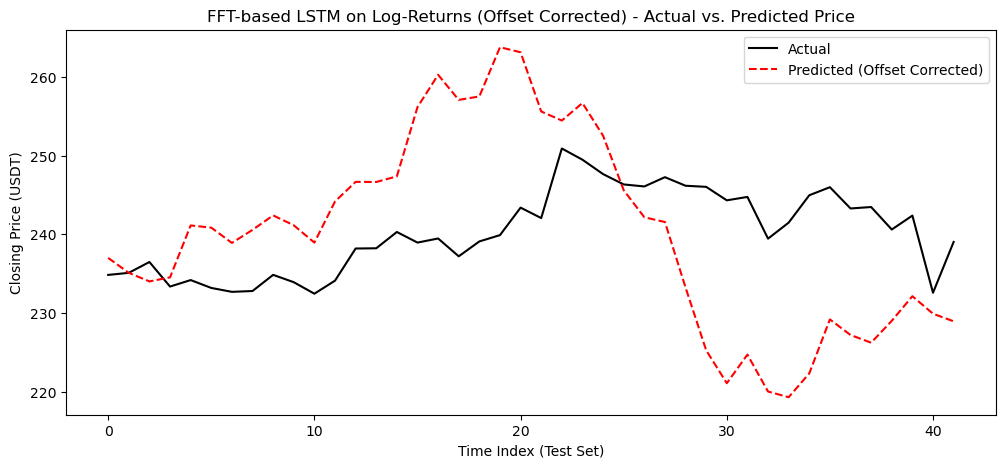

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import find_peaks

# ===============================
# 1. Load Dataset
# ===============================
file_path = "AAVE_ohlcv_data.csv"  # Adjust if needed
df = pd.read_csv(file_path)

# Convert timestamp and sort chronologically
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
df = df.sort_values("timestamp").reset_index(drop=True)

# Extract raw price
raw_price = df["price"].dropna().values
if len(raw_price) < 2:
    raise ValueError("Not enough price data for log-returns.")

# ===============================
# 2. Compute Log-Returns
# ===============================
log_price = np.log(raw_price)
log_returns = np.diff(log_price)  # length N-1 if raw_price has length N
N = len(log_returns)

mean_returns = np.mean(log_returns)
stationary_returns = log_returns - mean_returns  # remove DC component if desired

# ===============================
# 3. Compute FFT & PSD on Log-Returns
# ===============================
fft_result = np.fft.fft(stationary_returns)
frequencies = np.fft.fftfreq(N, d=1)  # assuming 1-hour intervals
psd = (np.abs(fft_result) ** 2) / N

# Only positive frequencies
pos_freqs = frequencies[:N // 2]
pos_psd = psd[:N // 2]

# ===============================
# 4. Filter Out Very Low Frequencies
# ===============================
freq_threshold = 0.0005  # skip frequencies below this
mask = (pos_freqs > freq_threshold)
filtered_freqs = pos_freqs[mask]
filtered_psd = pos_psd[mask]

# ===============================
# 5. Select Top K Frequencies
# ===============================
K = 5
sorted_indices = np.argsort(-filtered_psd)  # sort descending
top_k_indices = sorted_indices[:K]
dominant_freqs = filtered_freqs[top_k_indices]
dominant_psd = filtered_psd[top_k_indices]

print(f"Top {K} Frequencies (cycles/hour):", dominant_freqs)

# (Optional) Plot the PSD
plt.figure(figsize=(12, 5))
plt.plot(filtered_freqs, filtered_psd, label="PSD", color="blue")
plt.scatter(dominant_freqs, dominant_psd, color="red", label=f"Top {K} Frequencies")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Power")
plt.title("PSD of Log-Returns (Filtered) with Top-K Frequencies")
plt.legend()
plt.show()

# ===============================
# 6. Create Fourier Features
# ===============================
time_indices = np.arange(N)  # 0..N-1 for log_returns
fourier_feats = []

for f in dominant_freqs:
    sin_feat = np.sin(2 * np.pi * f * time_indices)
    cos_feat = np.cos(2 * np.pi * f * time_indices)
    fourier_feats.append(sin_feat)
    fourier_feats.append(cos_feat)

if fourier_feats:
    fourier_feats = np.stack(fourier_feats, axis=1)  # shape (N, 2*K)
else:
    fourier_feats = np.zeros((N, 0))

print("Fourier features shape:", fourier_feats.shape)

# We'll also include the raw log_returns as a feature
log_returns_feat = log_returns.reshape(-1, 1)  # shape (N,1)
X_features = np.concatenate([log_returns_feat, fourier_feats], axis=1)
print("Combined feature matrix shape:", X_features.shape)

# ===============================
# 7. Create Sequences for LSTM
# ===============================
window_size = 12

def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i : i+window])
        y_seq.append(y[i + window])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_features, log_returns, window_size)
print("Sequence shape:", X_seq.shape, "Target shape:", y_seq.shape)

# ===============================
# 8. Time-Based Split
# ===============================
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ===============================
# 9. Define LSTM Model
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_dim = X_features.shape[1]  # (1 + 2*K)
hidden_dim = 36
num_layers = 2
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 10. Train the LSTM
# ===============================
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

# ===============================
# 11. Evaluate the Model
# ===============================
model.eval()
with torch.no_grad():
    preds_test = model(X_test_tensor)
    test_loss = criterion(preds_test, y_test_tensor).item()
    print(f"\nTest MSE Loss (Log-Returns): {test_loss:.6f}")

preds_test_np = preds_test.numpy().flatten()
y_test_np = y_test.flatten()

# ===============================
# 12. Reconstruct Price from Log-Returns
# ===============================
# We'll start from the last known log_price before the test set.
last_train_log_price = log_price[window_size + split_idx]

# We'll build the predicted log_prices in the test set by cumulatively summing from that reference.
predicted_log_prices = [last_train_log_price]
for r in preds_test_np:
    next_log_price = predicted_log_prices[-1] + r
    predicted_log_prices.append(next_log_price)

# We'll do the same for actual log-returns
actual_log_prices = [last_train_log_price]
for r in y_test_np:
    next_log_price = actual_log_prices[-1] + r
    actual_log_prices.append(next_log_price)

# ---- Offset Correction to Match First Test Point ----
# Force the first predicted log_price to match the first actual log_price
offset = actual_log_prices[1] - predicted_log_prices[1]
for i in range(len(predicted_log_prices)):
    predicted_log_prices[i] += offset

# Convert log_prices to raw prices
preds_price = np.exp(predicted_log_prices)
actual_price = np.exp(actual_log_prices)

# ===============================
# 13. Plot Actual vs. Predicted in Original Scale
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(actual_price, label="Actual", color="black")
plt.plot(preds_price, label="Predicted (Offset Corrected)", linestyle="--", color="red")
plt.title("FFT-based LSTM on Log-Returns (Offset Corrected) - Actual vs. Predicted Price")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Closing Price (USDT)")
plt.legend()
plt.show()
